- Problem definition: Given more than one features at each time stamp in the past, predict the Global_active_power at a single time-stamp in the future.

In [1]:
#imports

import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

# gloabl params for all matplotlib plots
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [2]:
zip_path = tf.keras.utils.get_file( 
    origin='http://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip',

    fname='household_power_consumption.zip',
    extract=True)

print(zip_path)

20640916/20640916 [==============================] - 1s 0us/step
/root/.keras/datasets/household_power_consumption.zip


In [3]:
csv_path, _ = os.path.splitext(zip_path) 
print(csv_path)

/root/.keras/datasets/household_power_consumption


In [12]:
df = pd.read_csv('/root/.keras/datasets/household_power_consumption.txt', sep=';', 
                 parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'],index_col='dt')

In [5]:

df.head(5)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [13]:
df.shape

(2075259, 7)

In [14]:
#checking for missing values
df.columns[df.isnull().any()]

Index(['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3'],
      dtype='object')

In [15]:
#removing missing values
df=df.interpolate(method ='linear', limit_direction ='forward')

In [16]:
df.columns[df.isnull().any()]

Index([], dtype='object')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f202c5e4f50>,
      dtype=object)

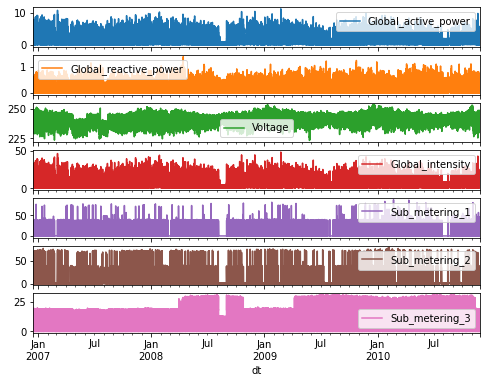

In [10]:
df.plot(subplots=True)

In [17]:
#lets only use 3 features for prediction, remember we can use any no of features
df=df[['Global_active_power','Global_reactive_power','Global_intensity']]


In [35]:
#first step is to standardize  or normalize the dataset...remember to only use training data 
# Standardize data
train_split = 1800000  

multi_single = df.values
data_mean = multi_single[:train_split].mean(axis=0)
data_std = multi_single[:train_split].std(axis=0)

multi_single= (multi_single-data_mean)/data_std

In [36]:
#defining a function to get our data in multi variate data
# Same as univariate_data above.

# New params:
# step: instead of taking data for each 1min as in pur data, we can say we want to use 1 reading every 10 min
# single_step: lables from single timestamp or multiple timesteps


def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step) # step used here.
    data.append(dataset[indices])

    if single_step: # single_step used here.
      labels.append(target[i+target_size]) 
    else:
      labels.append(target[i:i+target_size]) 

  return np.array(data), np.array(labels)

In [37]:
# Generate data
train_split=1500000
test_split=1800000

past_history = 300  #(say we want to consider history of last 5 hours so past history is 5 X 60)
future_target = 10   # say we want output value after 10 mins, we can keep it 0 for current value prediction )
STEP = 6  # one obs every 6 min  (instead of taking data for each 1min as in pur data, we can say we want to use 1 reading every 6  min)





x_train_single, y_train_single = multivariate_data(multi_single, multi_single[:, 1], 0,
                                                   train_split, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(multi_single,multi_single[:, 1],
                                               train_split, test_split, past_history,
                                               future_target, STEP,
                                               single_step=True)

x_test_single, y_test_single = multivariate_data(multi_single,multi_single[:, 1],
                                               test_split, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

print(x_train_single.shape)
print(y_train_single.shape)
print(x_val_single.shape)
print(y_val_single.shape)
print(x_test_single.shape)
print(y_test_single.shape)



(1499700, 50, 3)
(1499700,)
(299700, 50, 3)
(299700,)
(274949, 50, 3)
(274949,)


In [38]:
BATCH_SIZE = 256 # bacth size in batch-SGD/variants
BUFFER_SIZE = 10000 # for shuffling the dataset

train_multivariate = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_multivariate = train_multivariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
#https://www.tensorflow.org/api_docs/python/tf/data/Dataset#repeat

val_multivariate = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_multivariate = val_multivariate.batch(BATCH_SIZE).repeat()


test_multivariate = tf.data.Dataset.from_tensor_slices((x_test_single, y_test_single))
test_multivariate = test_multivariate.batch(BATCH_SIZE)



print(train_multivariate)
print(val_multivariate)
print(test_multivariate)

<RepeatDataset element_spec=(TensorSpec(shape=(None, 50, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>
<RepeatDataset element_spec=(TensorSpec(shape=(None, 50, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>
<BatchDataset element_spec=(TensorSpec(shape=(None, 50, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>


In [39]:
# Model
STEPS_PER_EPOCH = 200
EPOCHS = 10

multivariate_single_step_model = tf.keras.models.Sequential()
multivariate_single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
multivariate_single_step_model.add(tf.keras.layers.Dense(1))

multivariate_single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

multivariate_single_step_history = multivariate_single_step_model.fit(train_multivariate, epochs=EPOCHS,
                                            steps_per_epoch=STEPS_PER_EPOCH,
                                            validation_data=val_multivariate,
                                            validation_steps=50)

Epoch 1/10
200/200 [==============================] - 8s 32ms/step - loss: 0.7723 - val_loss: 0.8106
Epoch 2/10
200/200 [==============================] - 7s 34ms/step - loss: 0.6845 - val_loss: 0.7608
Epoch 3/10
200/200 [==============================] - 6s 29ms/step - loss: 0.6034 - val_loss: 0.7973
Epoch 4/10
200/200 [==============================] - 6s 31ms/step - loss: 0.5310 - val_loss: 0.7534
Epoch 5/10
200/200 [==============================] - 6s 28ms/step - loss: 0.5746 - val_loss: 0.9458
Epoch 6/10
200/200 [==============================] - 6s 28ms/step - loss: 0.6482 - val_loss: 0.8856
Epoch 7/10
200/200 [==============================] - 6s 29ms/step - loss: 0.4935 - val_loss: 0.8713
Epoch 8/10
200/200 [==============================] - 6s 29ms/step - loss: 0.5799 - val_loss: 0.8103
Epoch 9/10
200/200 [==============================] - 6s 28ms/step - loss: 0.5264 - val_loss: 0.8409
Epoch 10/10
200/200 [==============================] - 6s 28ms/step - loss: 0.5189 - val_lo

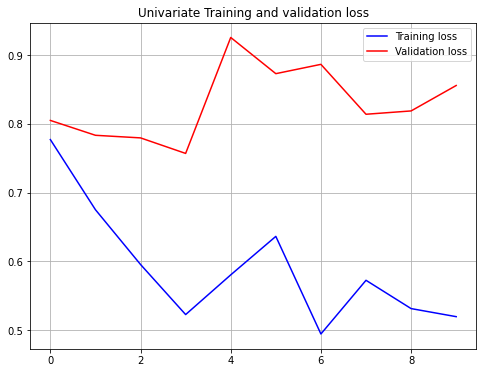

<Figure size 576x432 with 0 Axes>

In [34]:

def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()
  plt.grid()

  plt.show()



plot_train_history(multivariate_single_step_history,
                   'Univariate Training and validation loss')
plt.savefig('file2.png',dpi=300)

In [40]:
print("Evaluate")
result = multivariate_single_step_model.evaluate(test_multivariate)
print(result)

Evaluate
1075/1075 [==============================] - 16s 15ms/step - loss: 0.7666
0.7666165232658386
